In [1]:
from juliacall import Main as jl
jl.seval("""
         import Pkg
         ENV["JULIA_SSL_CA_ROOTS_PATH"]=""
         ENV["JULIA_PKG_USE_CLI_GIT"]=true
         Pkg.add(url=\"https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git\")
         """)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


    Updating git-repo `https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git`
   Resolving package versions...
    Updating `C:\Users\mking\.julia\environments\pyjuliapkg\Project.toml`
  [a1edf54d] ~ KLLS v1.0.0-DEV `https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git#main`
    Updating `C:\Users\mking\.julia\environments\pyjuliapkg\Manifest.toml`
  [a1edf54d] ~ KLLS v1.0.0-DEV `https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/MPF-Optimization-Laboratory/KLLS.jl.git#main`
Precompiling project...
  ✓ SciMLBase → SciMLBasePythonCallExt
  ✓ DiffEqBase → DiffEqBaseChainRulesCoreExt
  ✓ LinearSolve → LinearSolveEnzymeExt
  ✓ SimpleNonlinearSolve → SimpleNonlinearSolveChainRulesCoreExt
  ✓ NonlinearSolve
  ✓ KLLS
  6 dependencies successfully precompiled in 106 seconds. 194 already precompiled.


In [113]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np
import random as rd

# For MNIST data download
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import mnist_vae.vae as vae
plt.style.use('dark_background')
def to_im(x):
    return x.cpu().detach().numpy().reshape((28, 28))

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
path = Path()
data_dir = path

test_root = os.path.join(data_dir, "data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Importing above, no need to re-run

In [105]:
jl.seval("""
         using KLLS
         solve = KLLS.solve!
         rescale = KLLS.scale!
         maximize = KLLS.maximize!
         regularize = KLLS.regularize!
         dObj = KLLS.dObj!
         dGrad = KLLS.dGrad!
         """);

In [108]:

net = vae.VAE()
net.load_state_dict(torch.load('mnist_vae/weights/vae_epoch_25.pth'))


<All keys matched successfully>

In [109]:
def objective(q,g):
    value = jl.dObj(kl,q)
    gradient_value = jl.dGrad(kl,q,g)
    return [value, gradient_value]

def scalar_obj(q):
    value = jl.dObj(kl,q)
    return value


In [110]:
#{ Dataset
#test_data = datasets.MNIST(
#    root="data",
##   download=True,
#    transform=ToTensor()
# )
#dataloader = torch.utils.data.DataLoader(test_data, batch_size=1,
#                                             shuffle=False)

# commented out for now; but code for dcgan

In [112]:
#test_img = next(iter(dataloader))

#test_img_for_plot = test_img[0][0].detach().numpy()
#plt.imshow(np.reshape(test_img_for_plot,[28,28]), cmap='gray');

# as above

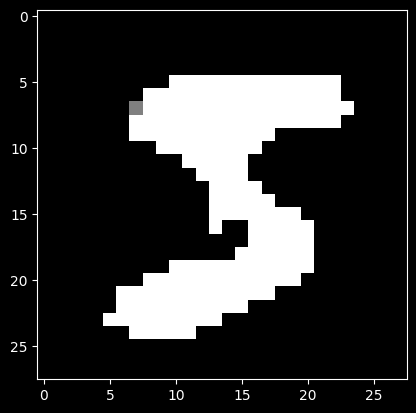

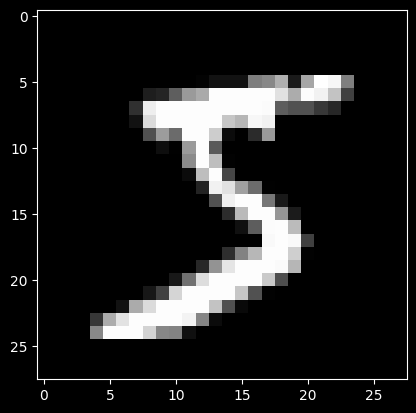

In [141]:
im0 = datasets.MNIST(root=test_root, train=True).data[0].float()
im1 = datasets.MNIST(root=test_root, train=True).data[1].float()
im2 = datasets.MNIST(root=test_root, train=True).data[2].float()
im0_reconstructed = to_im(net(im0)[0])
plt.figure()
plt.imshow(im0_reconstructed.reshape(28,28),cmap='gray')
plt.figure()
plt.imshow(im0.reshape(28,28),cmap='gray')

In [117]:
datasets.MNIST(root=test_root, train=True).data.size()[0]

60000

In [132]:
# Create and save matrix A in feature space. (Very long, no need to re-run)

latent_size = 40;
A = np.zeros([40,60000])
for i in range(datasets.MNIST(root=test_root, train=True).data.size()[0]):
    current_img = datasets.MNIST(root=test_root, train=True).data[i].float();
    (mu, logvar) = net.encode(current_img.reshape(-1, 784));
    feature_vec = np.concatenate((mu[0].detach().numpy() ,logvar[0].detach().numpy()));
    A[:,i] = feature_vec
    if((i+1)%1000==0):
        print(i)
np.save("mnist_featureA_vae",A)
    

999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
17999
18999
19999
20999
21999
22999
23999
24999
25999
26999
27999
28999
29999
30999
31999
32999
33999
34999
35999
36999
37999
38999
39999
40999
41999
42999
43999
44999
45999
46999
47999
48999
49999
50999
51999
52999
53999
54999
55999
56999
57999
58999
59999


In [165]:
b = im0 + np.random.randn()

In [166]:
np.linalg.norm(b)
b.size()

b_noisy = b + (0.03*np.linalg.norm(b))*torch.randn(28,28)

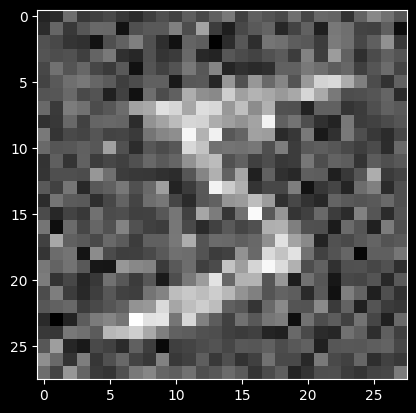

In [167]:
plt.imshow(b_noisy,cmap = 'gray')

In [174]:
A= np.array(A)
A = np.float64(A)

(mu, logvar) = net.encode(b_noisy.reshape(-1, 784));
target_b = np.concatenate((mu[0].detach().numpy() ,logvar[0].detach().numpy()));
target_b = np.float64(target_b)


In [179]:
kl = jl.KLLSModel(A,target_b)
jl.regularize(kl,0.1)

KL regularized least-squares
   m =         40  bNrm = 2.1e+03
   n =      60000  λ    = 1.0e-01
                   τ    = 1.0e+00


In [ ]:
p = jl.solve(kl, logging=1,max_time= 10000.0)


KL regularized least-squares
   m =         40  bNrm = 2.1e+03
   n =      60000  λ    = 1.0e-01
                   τ    = 1.0e+00

Solver parameters:
   atol = 6.1e-06  max time (sec) =   10000
   rtol = 6.1e-06  target ∥r∥<ε   = 1.3e-02

   iter   dual Obj    ∥∇dObj∥          Δ      Δₐ/Δₚ  cg its      cg msg
      0  -1.00e+00   1.27e+03    1.0e+02   0.0e+00       0             
      1  -3.31e+01   5.57e+02    1.0e+02   1.1e+00       6            ✓
      2  -1.30e+04   1.10e+03    1.5e+02   1.3e+00      30            ⊕
      3  -1.44e+04   1.33e+03    1.5e+02   2.1e-02       1            ⊕
      4  -1.70e+04   1.01e+03    1.5e+02   2.2e-02       1            ⊕
      5  -3.85e+04   1.22e+03    1.5e+02   1.4e-01       1            ⊕
      6  -6.21e+04   5.06e+02    1.5e+02   1.3e-01       1            ⊕
      7  -8.75e+04   1.23e+03    1.5e+02   3.4e-01       1            ⊕
      8  -1.34e+05   4.92e+02    1.5e+02   2.6e-01       1            ⊕
      9  -1.40e+05   1.09e+03    1.5e+0